# Project 0: Stroke classification task

Nichanok Auevechanichkul, 824925, Master student of bioinformatics 



## Data

- **Target**: imbalance binary value of stroke 
    - 10%: 1 (stroke)
    - 90%: 0 (healthy)

- **Features**: 

1) id (int): key id
2) gender: categorical feature with male and female
3) age (int): numerical feature
4) hypertension: categorical feature with healthy (0) and unhealty (1)
5) heart_disease:categorical feature with healthy (0) and unhealty (1)
6) work_type: categorical feature
    - goverment job
    - never worked
    - private
    - self-employed
    - children
7) Residence_type: categorical feature with rural and urban
8) avg_glucose_level (int): 8% missing values
9) bmi (int): 31% missing values
10) smoking_status: categorical feature 
    - unknown:
    - formerly smoked
    - never smoked
    - smokes
    


- **Training Data**: 5000 instances
- **Test Data**: 1000 instances



In [21]:
#import all necessary libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from statistics import mean
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, make_scorer,roc_curve, auc, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier



import joblib #for parallel running
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
#load data
df = pd.read_csv("train.csv")
missing_data = df.isnull().sum()
print(missing_data)

df.head()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
work_type               0
Residence_type          0
avg_glucose_level     393
bmi                  1552
smoking_status          0
stroke                  0
dtype: int64


id  gender  age  hypertension  heart_disease      work_type Residence_type  \
0   0  Female   36             0              0        Private          Urban   
1   1  Female   79             0              0        Private          Urban   
2   2    Male   68             0              0        Private          Urban   
3   3    Male   34             0              0        Private          Rural   
4   4    Male   88             0              0  Self-employed          Rural   

   avg_glucose_level    bmi   smoking_status  stroke  
0          93.962305  33.72     never smoked       0  
1                NaN  31.32     never smoked       1  
2          99.642305  30.60  formerly smoked       0  
3          75.752305  29.76          Unknown       0  
4          92.352305  34.44     never smoked       0

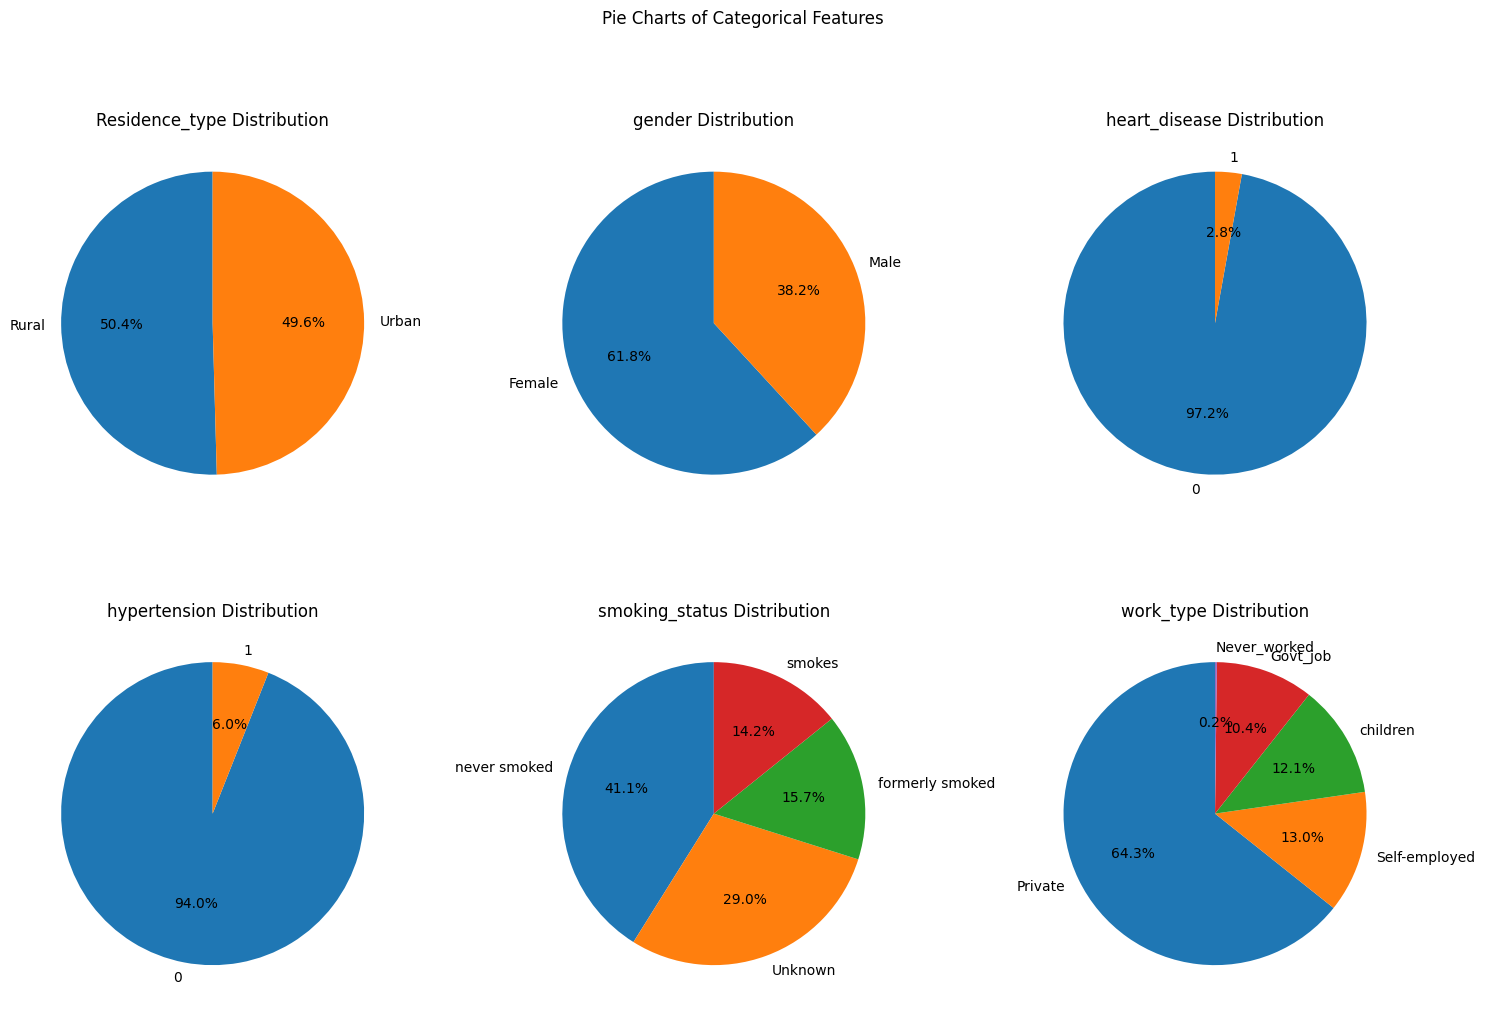

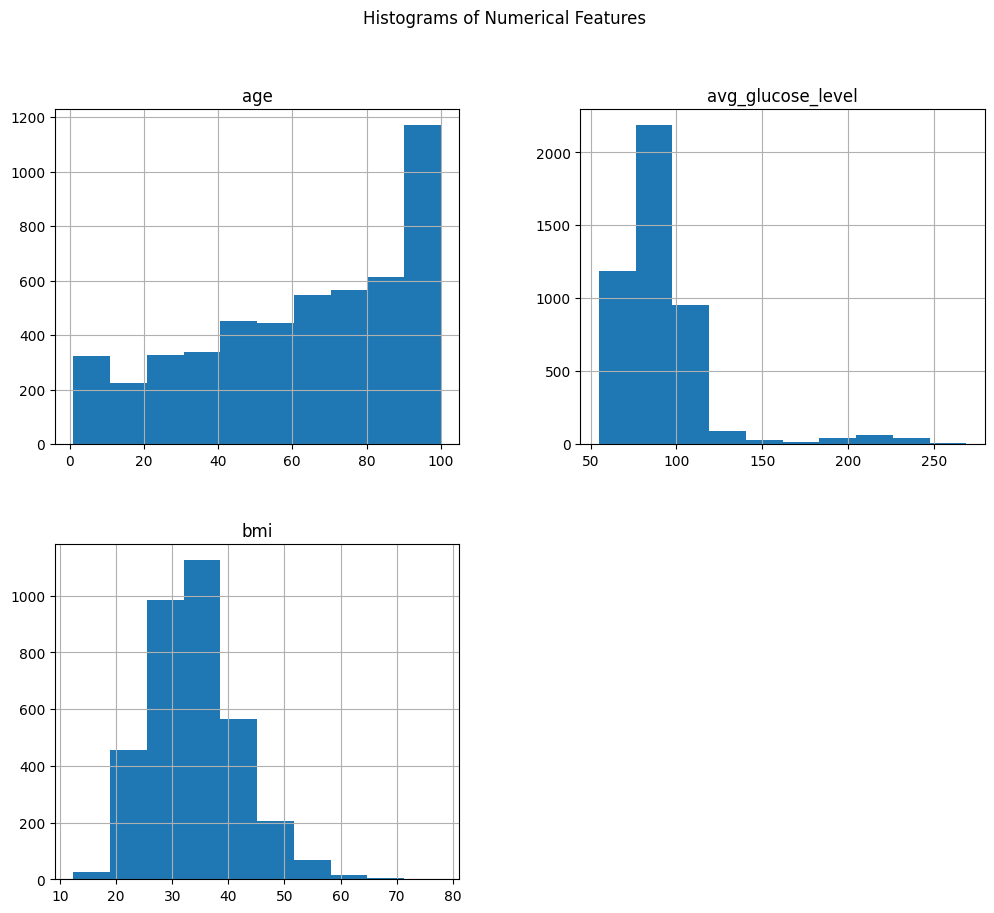

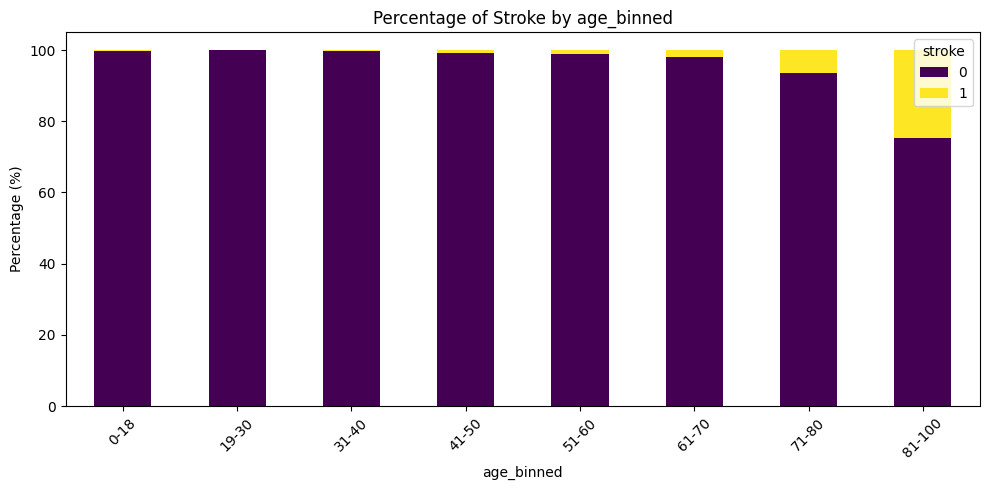

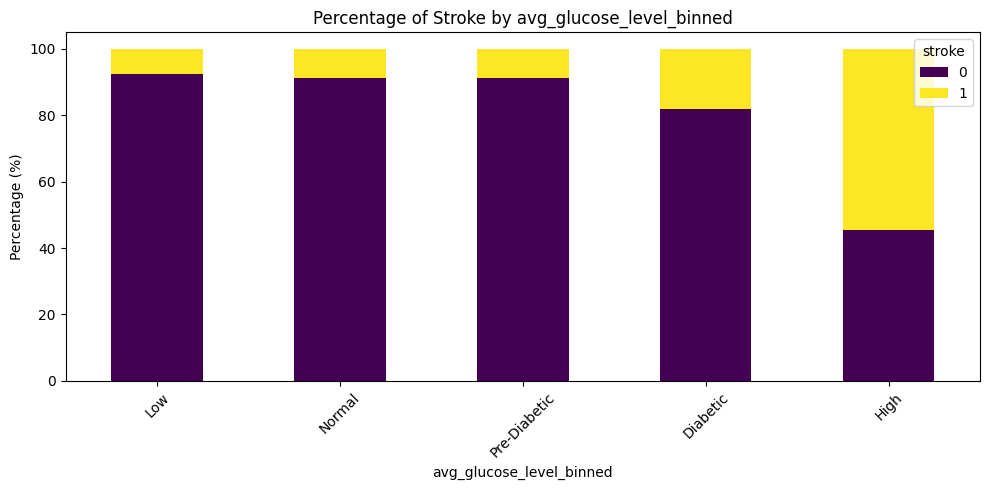

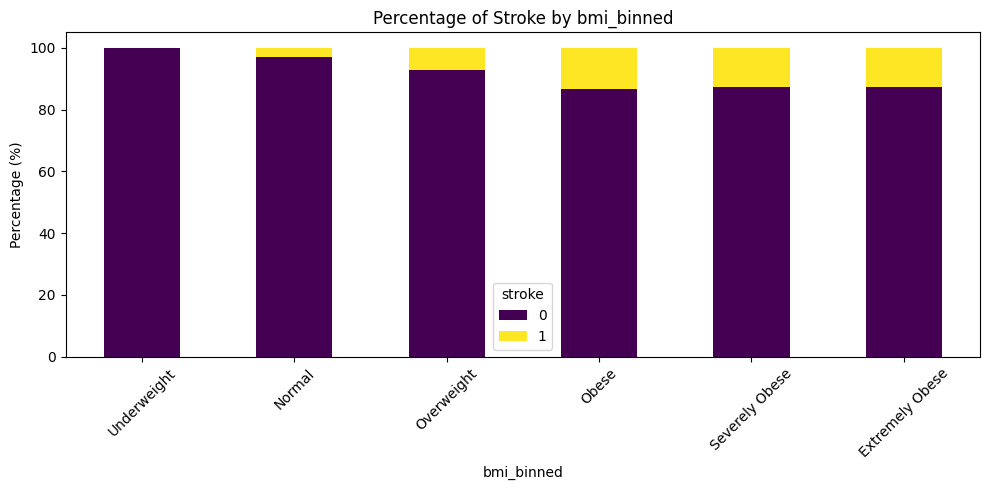

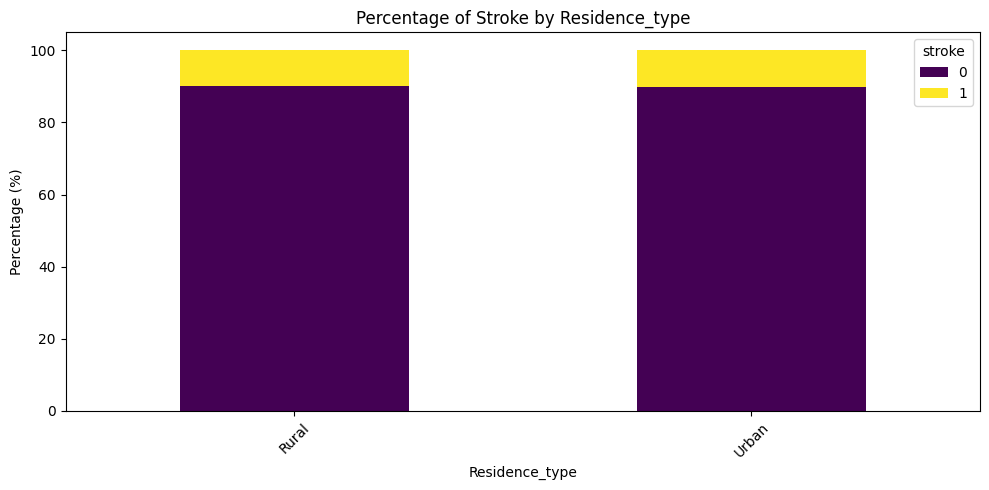

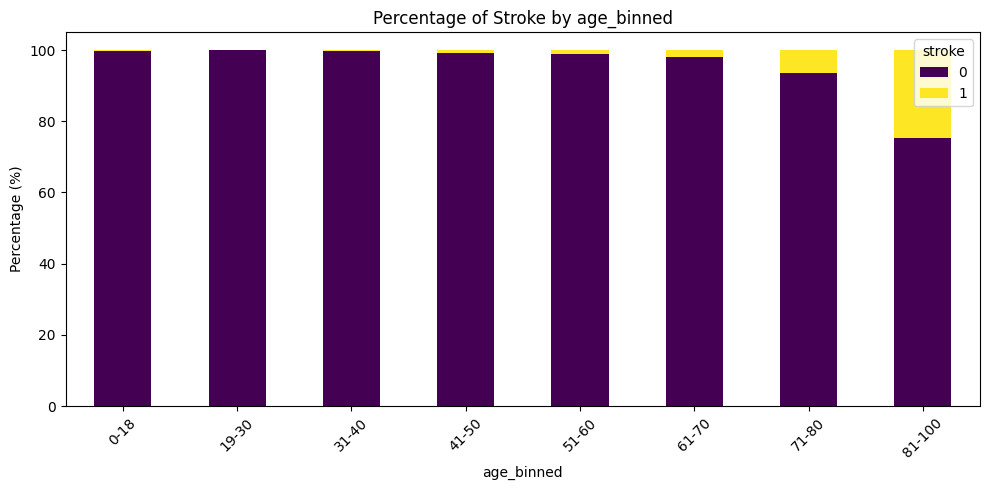

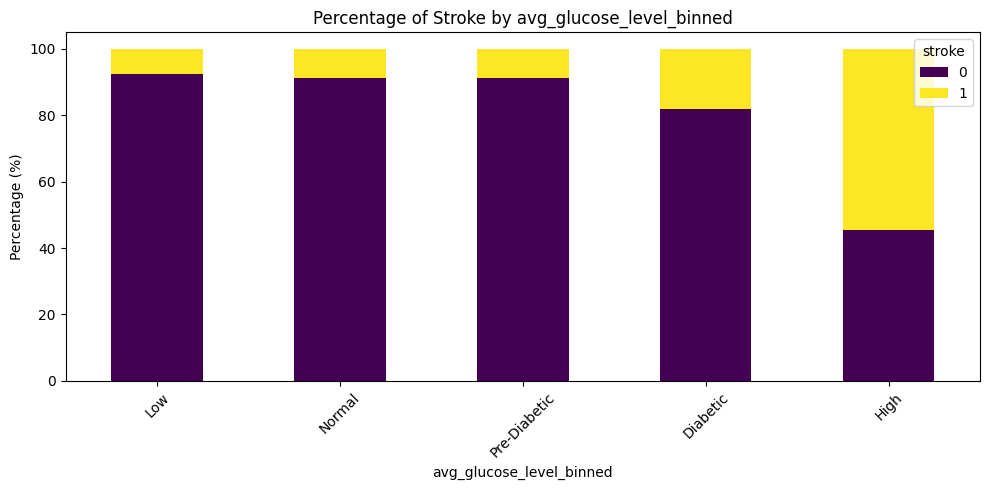

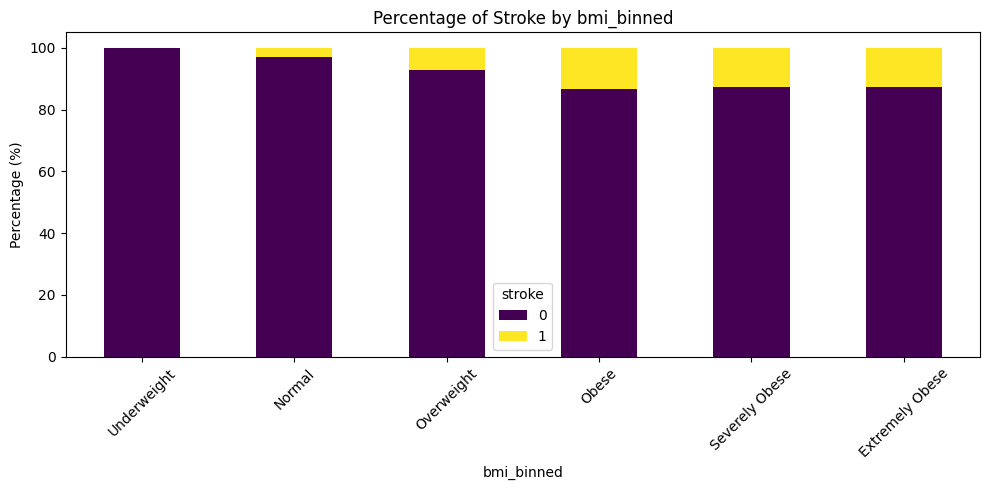

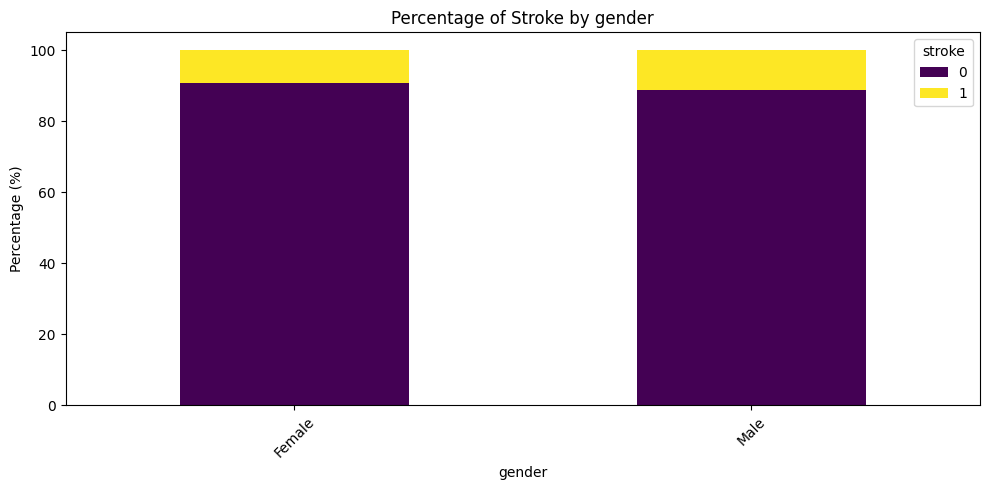

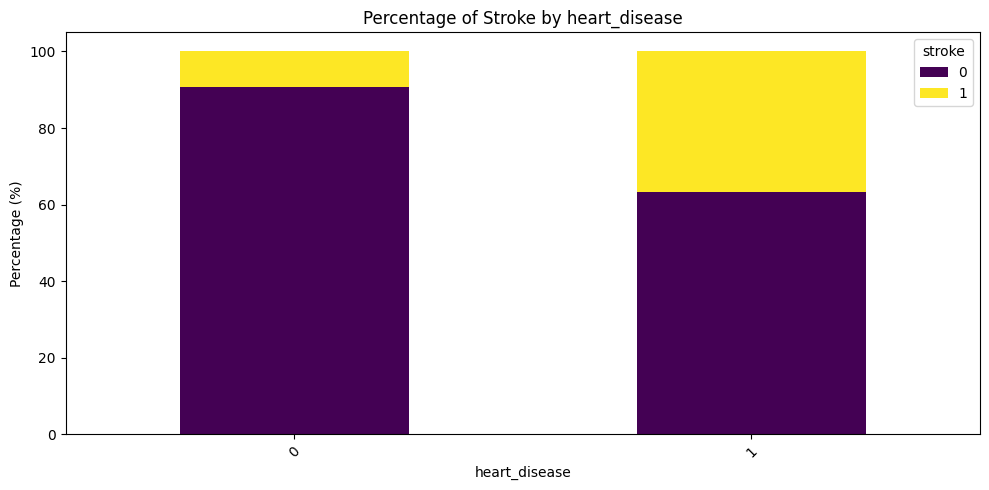

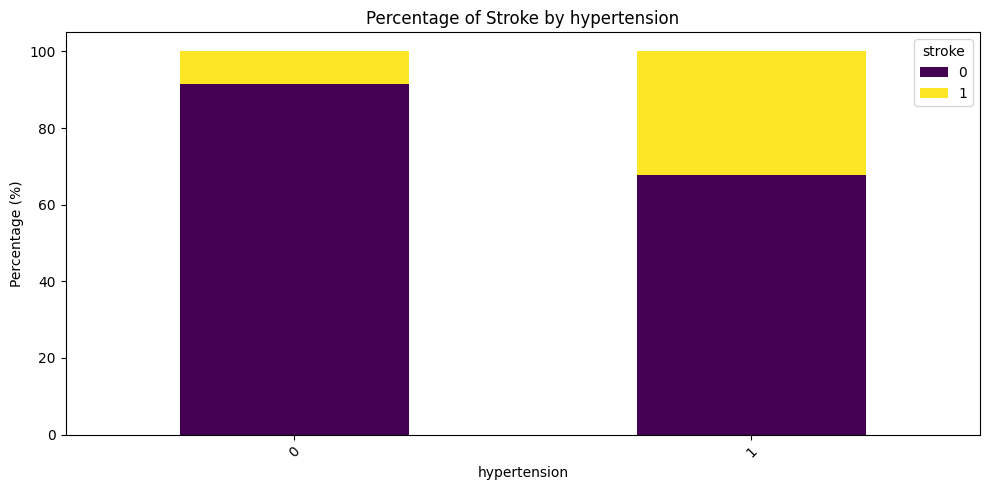

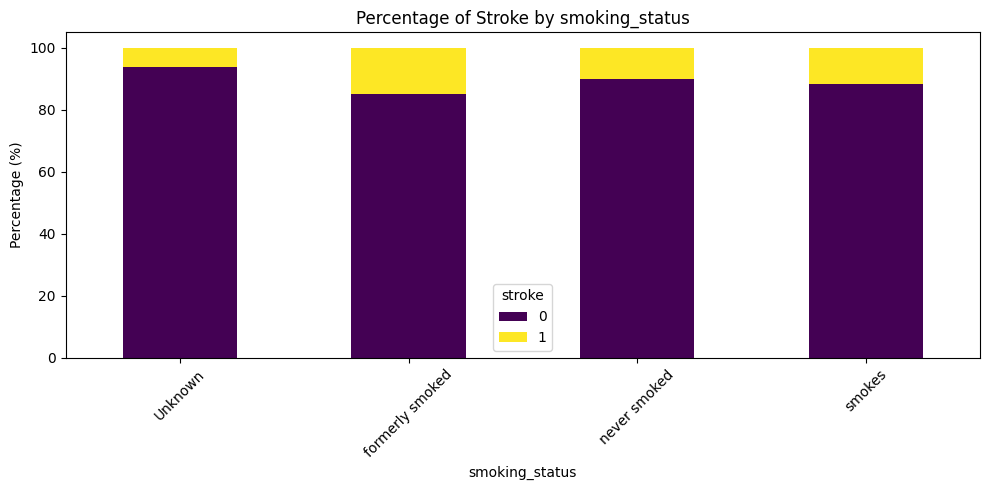

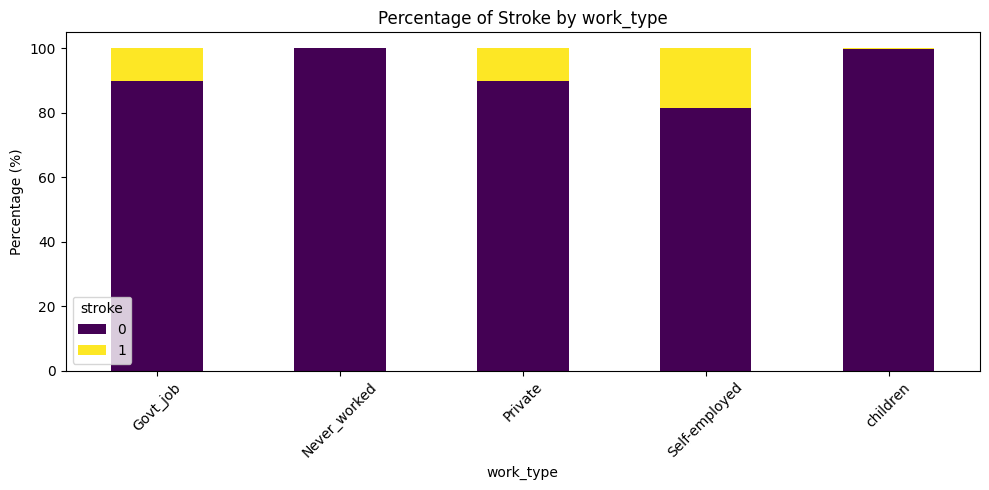

In [26]:
#Visualize each features in pie chart and histogram and plot the stroke proportion

# Define the numerical and categorical columns
numerical_columns = ['age', 'avg_glucose_level', 'bmi']
numerical_df = df[numerical_columns]

# Define categorical_df with remaining columns
categorical_columns = df.columns.difference(numerical_columns + ['id', 'stroke'])
categorical_df = df[categorical_columns]

# Number of categorical features
num_categoricals = len(categorical_df.columns)

# Calculate number of rows required for the plot
rows = num_categoricals // 3 + (num_categoricals % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each categorical feature in a pie chart
for i, column in enumerate(categorical_df.columns):
    value_counts = categorical_df[column].value_counts(dropna=False)
    value_counts.plot.pie(ax=axes[i], autopct='%.1f%%', startangle=90)
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Pie Charts of Categorical Features', y=1.05)
plt.show()

# Plot histograms for the numerical columns
numerical_df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Define bins for numerical columns
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
glucose_bins = [0, 70, 100, 140, 200, 300]
bmi_bins = [0, 18.5, 25, 30, 35, 40, 50]

# Create binned versions of the numerical columns
df['age_binned'] = pd.cut(df['age'], bins=age_bins, labels=["0-18", "19-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-100"])
df['avg_glucose_level_binned'] = pd.cut(df['avg_glucose_level'], bins=glucose_bins, labels=["Low", "Normal", "Pre-Diabetic", "Diabetic", "High"])
df['bmi_binned'] = pd.cut(df['bmi'], bins=bmi_bins, labels=["Underweight", "Normal", "Overweight", "Obese", "Severely Obese", "Extremely Obese"])

# Cross-tabulation and stacked bar plot for binned numerical columns (percentages)
binned_columns = ['age_binned', 'avg_glucose_level_binned', 'bmi_binned']
for column in binned_columns:
    crosstab = pd.crosstab(df[column], df['stroke'], normalize='index') * 100
    crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis')
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Cross-tabulation for categorical columns (percentages)
for column in df.columns.difference(numerical_columns + ['id', 'stroke']):
    crosstab = pd.crosstab(df[column], df['stroke'], normalize='index') * 100
    crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis')
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


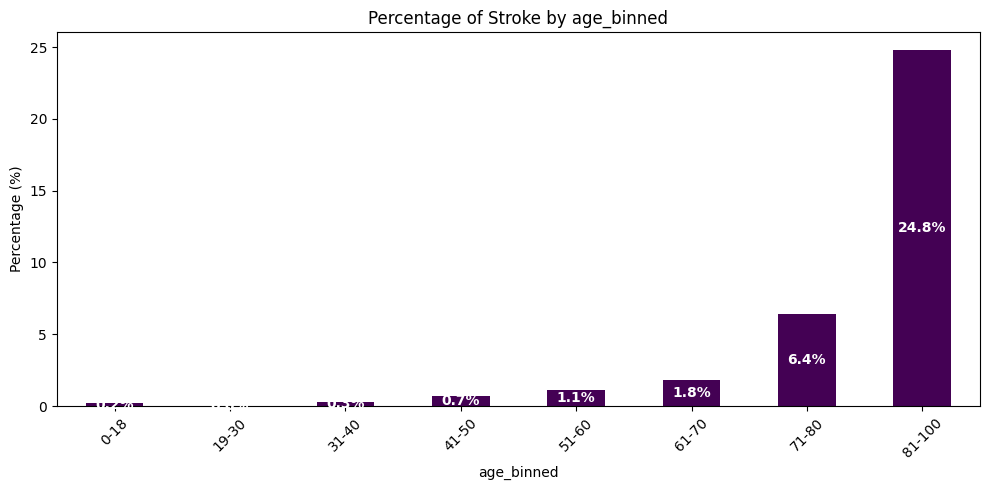

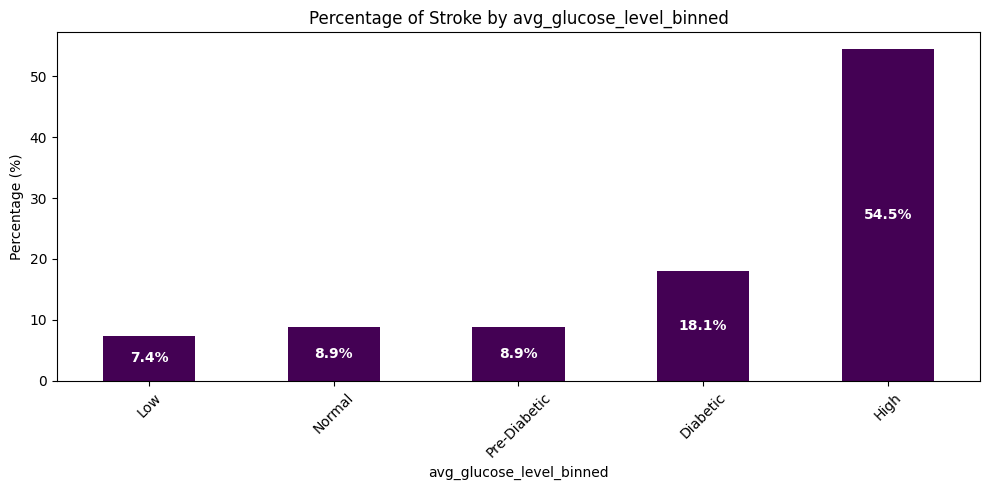

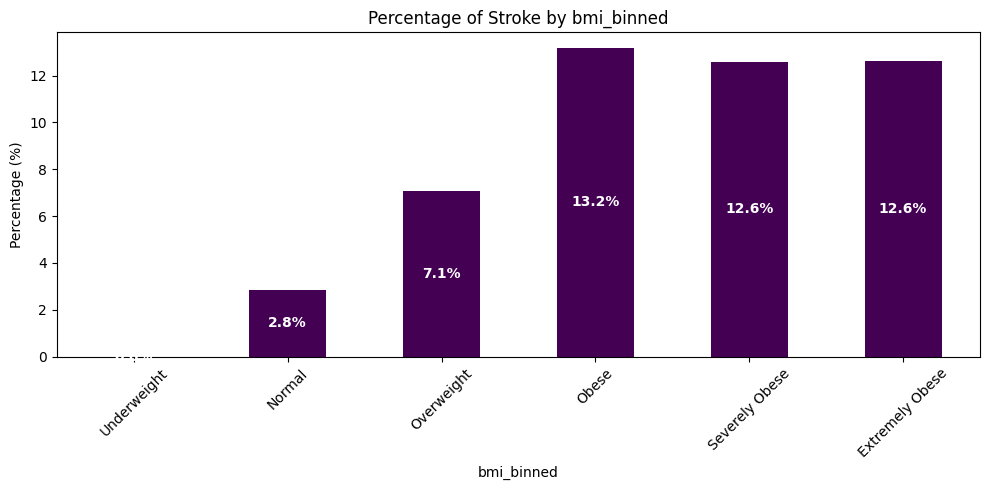

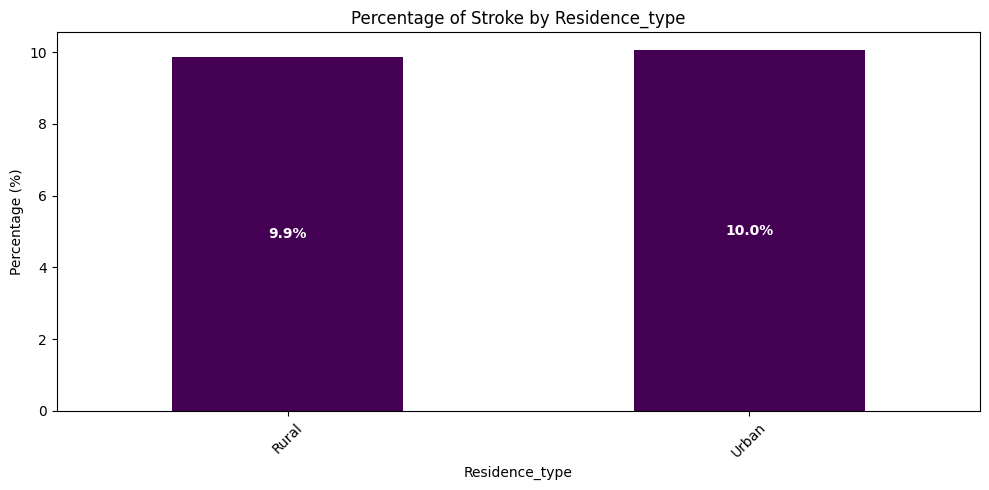

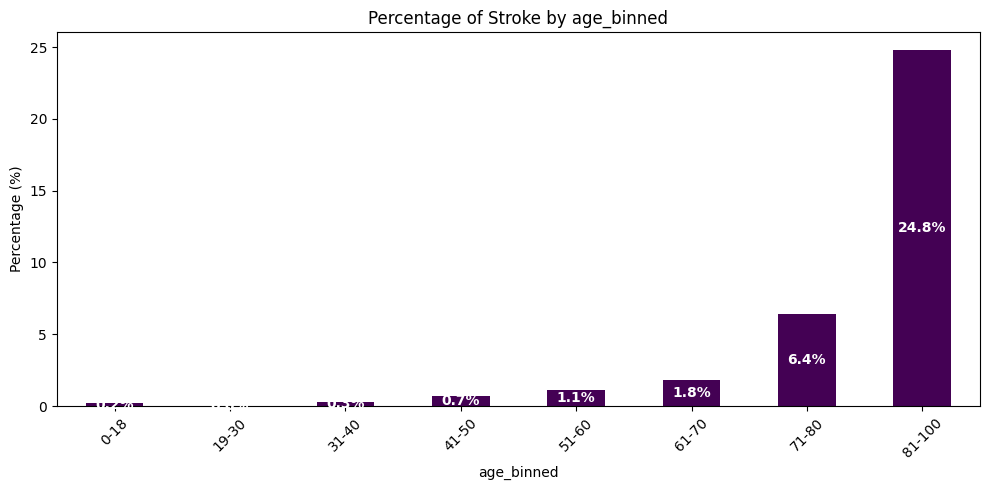

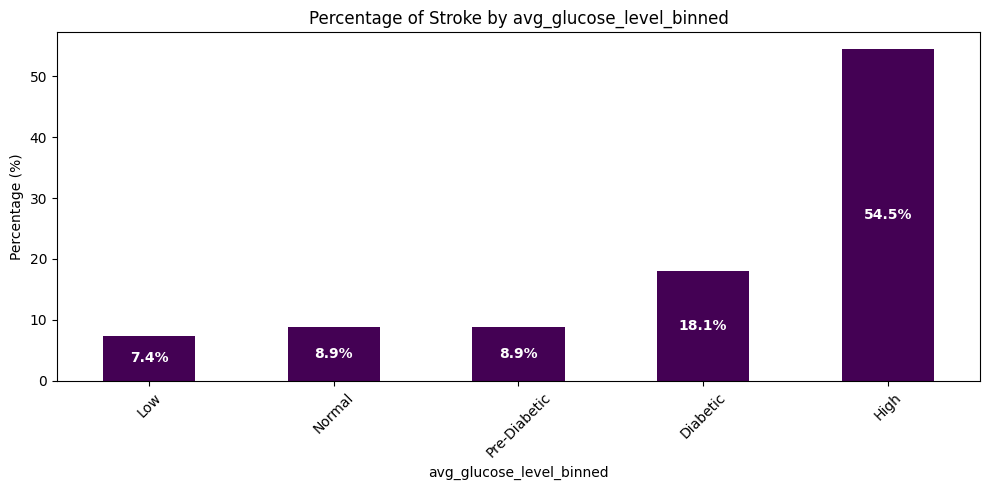

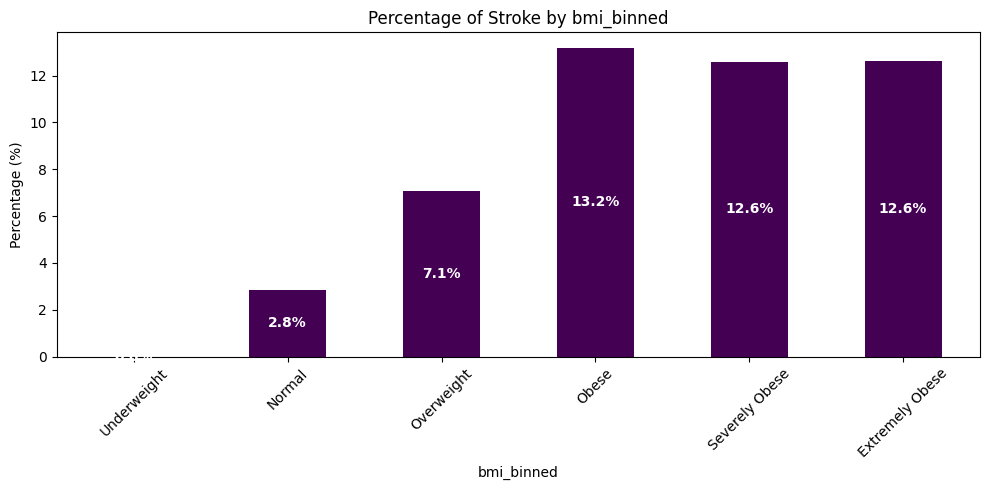

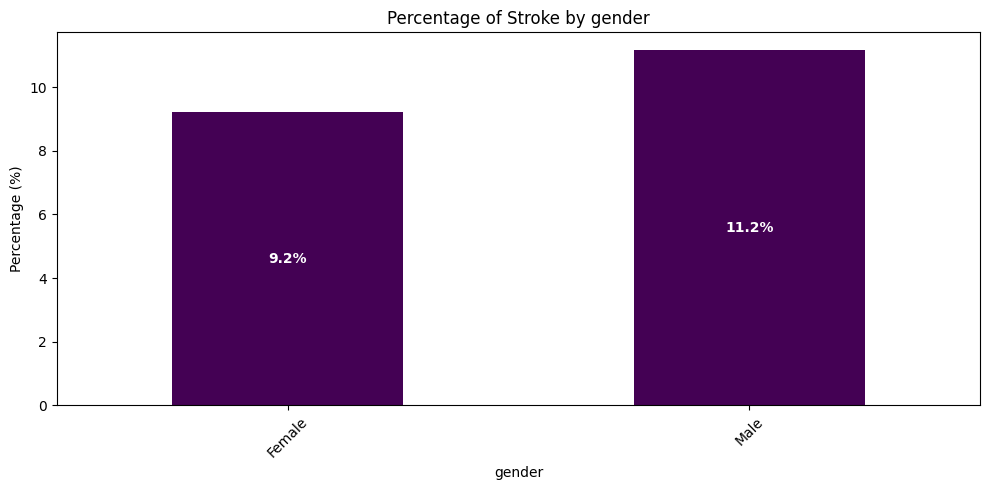

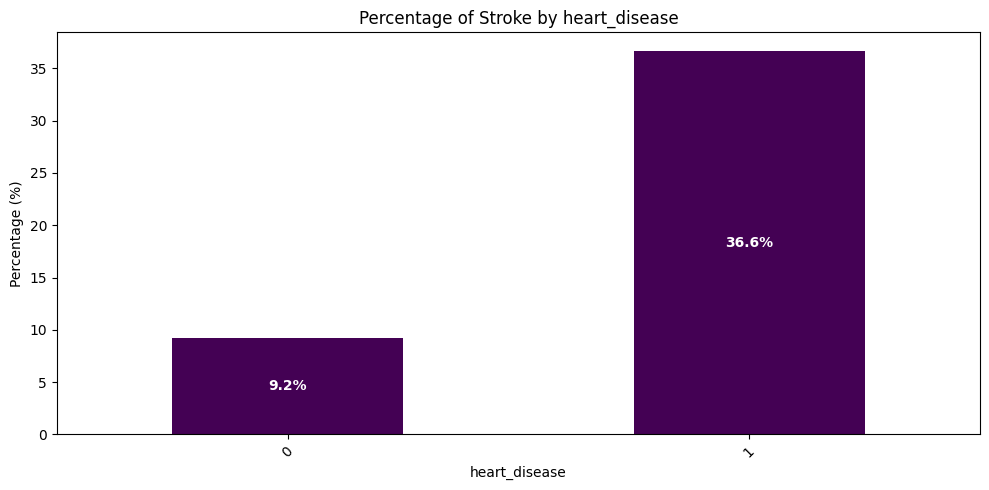

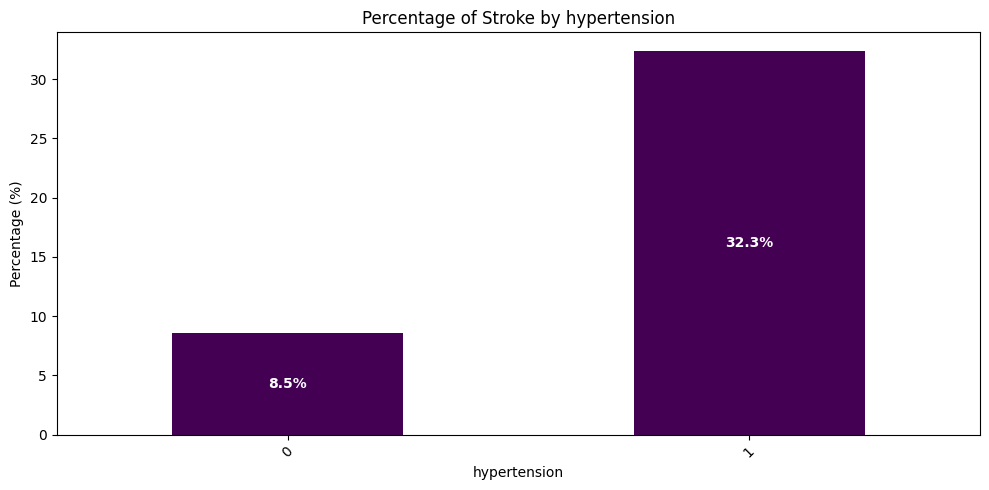

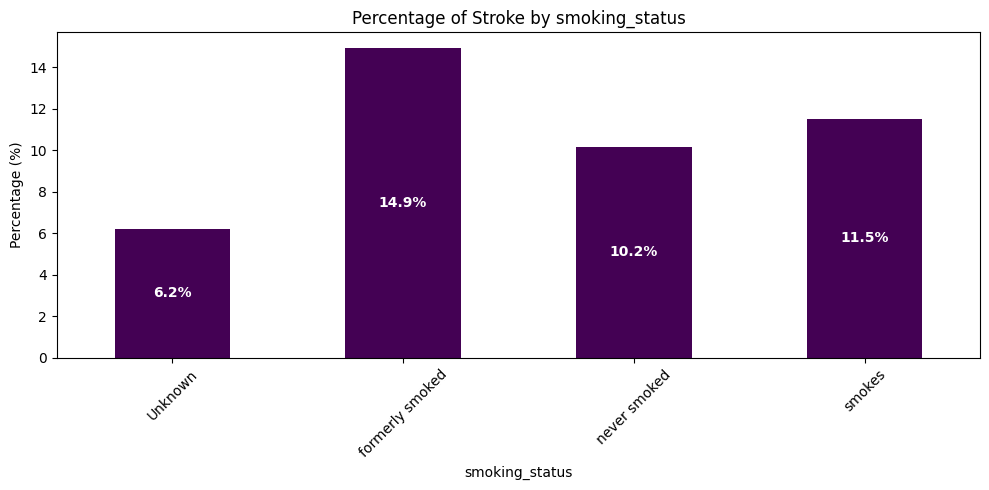

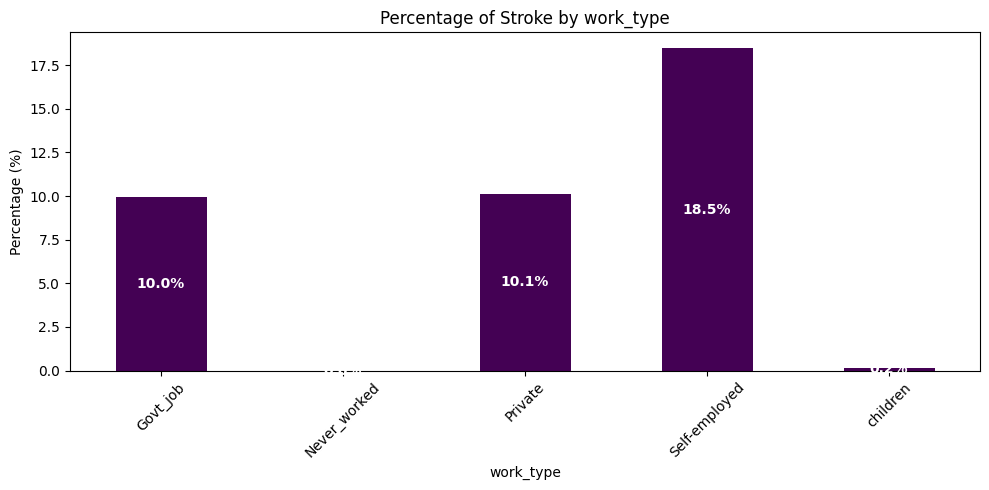

In [27]:
#Visualize data: Only the stroke proportion in each feature

# Function to add percentage labels to the bars in the plot
def add_percentage_labels(ax, crosstab):
    for p in ax.patches:
        percentage = f'{p.get_height():.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                    ha='center', va='center', fontsize=10, color='white', weight='bold')

# Cross-tabulation and stacked bar plot for binned numerical columns (percentages for stroke == 1)
binned_columns = ['age_binned', 'avg_glucose_level_binned', 'bmi_binned']
for column in binned_columns:
    # Create crosstab and filter only stroke == 1
    crosstab = pd.crosstab(df[column], df['stroke'], normalize='index') * 100
    crosstab = crosstab[[1]]  # Select only the column for stroke == 1
    
    # Plot the filtered crosstab
    ax = crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis', legend=False)
    
    # Add percentage labels to the bars
    add_percentage_labels(ax, crosstab)
    
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Cross-tabulation for categorical columns (percentages for stroke == 1)
for column in df.columns.difference(numerical_columns + ['id', 'stroke']):
    # Create crosstab and filter only stroke == 1
    crosstab = pd.crosstab(df[column], df['stroke'], normalize='index') * 100
    crosstab = crosstab[[1]]  # Select only the column for stroke == 1
    
    # Plot the filtered crosstab
    ax = crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis', legend=False)
    
    # Add percentage labels to the bars
    add_percentage_labels(ax, crosstab)
    
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Data proprocessing

- No duplicates
- Missing values: 
    1) average glucose level: positive skewness distribution with 8% missing value
        --> Simple Imputer with median
    2) bmi: positive skewness distribution with 31% missing value
        --> K-Nearlest Neighbor (KNN) imputer
- One hot encoder: to transfrom the categorical features into nummerical features
- No scaler require for the decision tree models

In [36]:
#Preprocessed data

#check duplicate
dup = df.duplicated()
print(df[dup])

# Drop the 'id' column as it's not needed
df = df.drop(columns=['id'])

# Define categorical and numerical columns
categorical_columns = ['gender', 'work_type', 'Residence_type', 'smoking_status']
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

# SimpleImputer for 'avg_glucose_level' with the 'median' strategy
simple_imputer = SimpleImputer(strategy='median')
df['avg_glucose_level'] = simple_imputer.fit_transform(df[['avg_glucose_level']])

# KNNImputer for 'bmi' with k-nearest neighbors imputation
knn_imputer = KNNImputer(n_neighbors=5)
df['bmi'] = knn_imputer.fit_transform(df[['bmi']])

# OneHotEncoder for categorical data
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical_data = ohe.fit_transform(df[categorical_columns])

# Create a DataFrame for the encoded categorical columns
encoded_categorical_df = pd.DataFrame(
    encoded_categorical_data, 
    columns=ohe.get_feature_names_out(categorical_columns)
)

# Concatenate the numerical columns and the encoded categorical columns
preprocessed_df = pd.concat([df[numerical_columns], encoded_categorical_df, df['stroke']], axis=1)

print("Missing values after preprocessed\n")

# Check for any remaining missing data
missing_data_preprocessed = preprocessed_df.isnull().sum()
print(missing_data_preprocessed)

preprocessed_df.head()

Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke, age_binned, avg_glucose_level_binned, bmi_binned]
Index: []
Missing values after preprocessed

age                               0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
stroke                            0
dtype: int64


age  avg_glucose_level    bmi  gender_Male  work_type_Never_worked  \
0   36          93.962305  33.72          0.0                     0.0   
1   79          86.352305  31.32          0.0                     0.0   
2   68          99.642305  30.60          1.0                     0.0   
3   34          75.752305  29.76          1.0                     0.0   
4   88          92.352305  34.44          1.0                     0.0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                1.0                      0.0                 0.0   
1                1.0                      0.0                 0.0   
2                1.0                      0.0                 0.0   
3                1.0                      0.0                 0.0   
4                0.0                      1.0                 0.0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                   1.0                             0.0   
1                   1.0                             0.0   
2                   1.0                             1.0   
3                   0.0                             0.0   
4                   0.0                             0.0   

   smoking_status_never smoked  smoking_status_smokes  stroke  
0                          1.0                    0.0       0  
1                          1.0                    0.0       1  
2                          0.0                    0.0       0  
3                          0.0                    0.0       0  
4                          1.0                    0.0       0

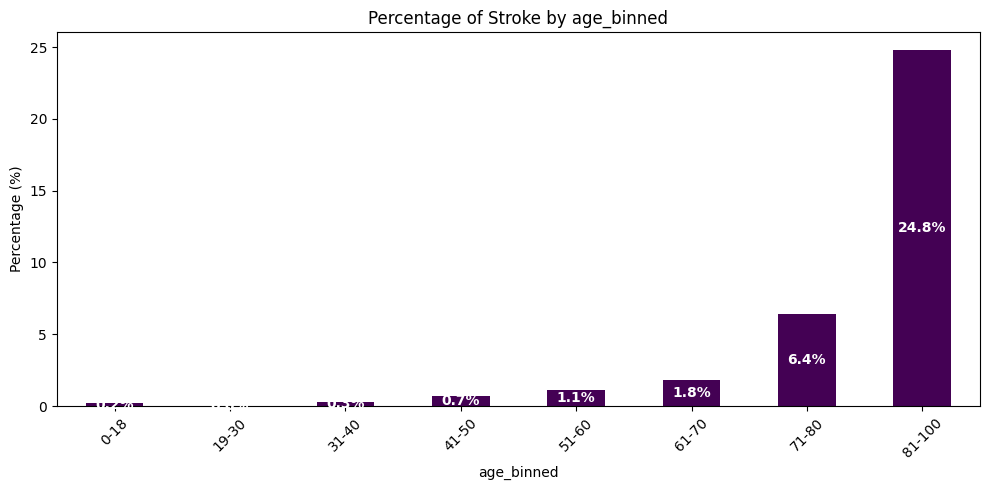

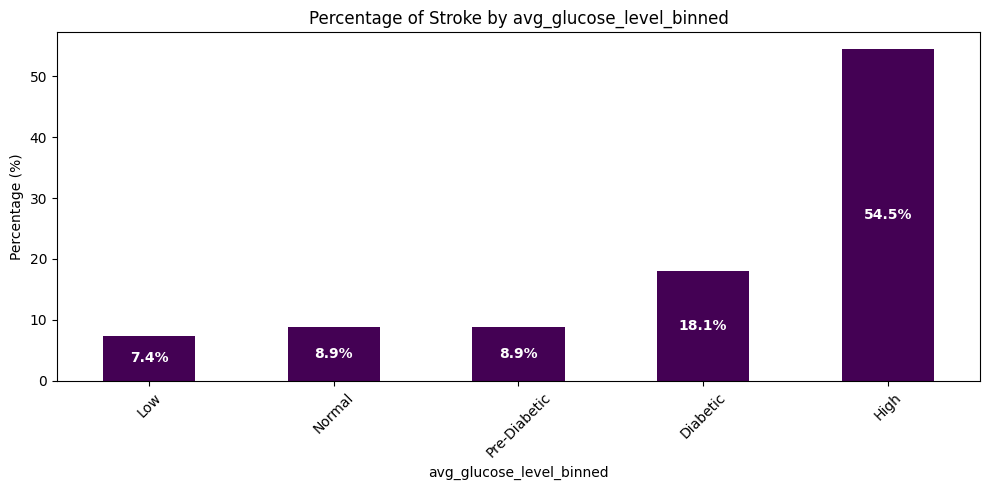

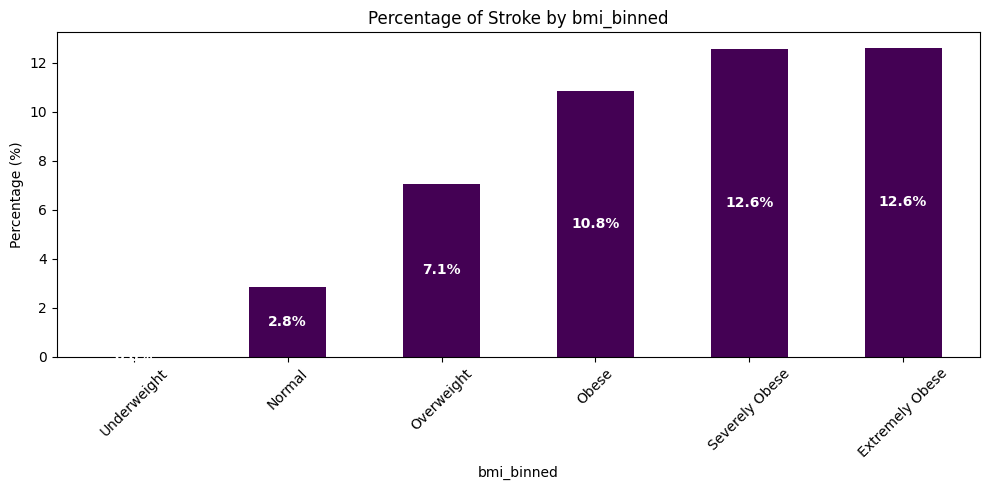

"# Cross-tabulation for categorical columns (percentages for stroke == 1)\nfor column in df.columns.difference(numerical_columns + ['id', 'stroke']):\n    # Create crosstab and filter only stroke == 1\n    crosstab = pd.crosstab(preprocessed_df[column], preprocessed_df['stroke'], normalize='index') * 100\n    crosstab = crosstab[[1]]  # Select only the column for stroke == 1\n    \n    # Plot the filtered crosstab\n    ax = crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis', legend=False)\n    \n    # Add percentage labels to the bars\n    add_percentage_labels(ax, crosstab)\n    \n    plt.title(f'Percentage of Stroke by {column}')\n    plt.ylabel('Percentage (%)')\n    plt.xlabel(column)\n    plt.xticks(rotation=45)\n    plt.tight_layout()\n    plt.show()"

In [29]:
#Check the data distribution after the data preprocessing
# Visualize data: Only the stroke proportion in each feature

# Function to add percentage labels to the bars in the plot
def add_percentage_labels(ax, crosstab):
    for p in ax.patches:
        percentage = f'{p.get_height():.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                    ha='center', va='center', fontsize=10, color='white', weight='bold')

# Cross-tabulation and stacked bar plot for binned numerical columns (percentages for stroke == 1)
binned_columns = ['age_binned', 'avg_glucose_level_binned', 'bmi_binned']
for column in binned_columns:
    # Create crosstab and filter only stroke == 1
    crosstab = pd.crosstab(preprocessed_df[column], preprocessed_df['stroke'], normalize='index') * 100
    crosstab = crosstab[[1]]  # Select only the column for stroke == 1
    
    # Plot the filtered crosstab
    ax = crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis', legend=False)
    
    # Add percentage labels to the bars
    add_percentage_labels(ax, crosstab)
    
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

"""# Cross-tabulation for categorical columns (percentages for stroke == 1)
for column in df.columns.difference(numerical_columns + ['id', 'stroke']):
    # Create crosstab and filter only stroke == 1
    crosstab = pd.crosstab(preprocessed_df[column], preprocessed_df['stroke'], normalize='index') * 100
    crosstab = crosstab[[1]]  # Select only the column for stroke == 1
    
    # Plot the filtered crosstab
    ax = crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis', legend=False)
    
    # Add percentage labels to the bars
    add_percentage_labels(ax, crosstab)
    
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()"""


In [ ]:
#Visualize each features in pie chart and histogram and plot the stroke proportion

# Define the numerical and categorical columns
numerical_columns = ['age', 'avg_glucose_level', 'bmi']
numerical_df = preprocessed_df[numerical_columns]

# Define categorical_df with remaining columns
categorical_columns = preprocessed_df.columns.difference(numerical_columns + ['id', 'stroke'])
categorical_df = preprocessed_df[categorical_columns]

# Number of categorical features
num_categoricals = len(categorical_df.columns)

# Calculate number of rows required for the plot
rows = num_categoricals // 3 + (num_categoricals % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each categorical feature in a pie chart
for i, column in enumerate(categorical_df.columns):
    value_counts = categorical_df[column].value_counts(dropna=False)
    value_counts.plot.pie(ax=axes[i], autopct='%.1f%%', startangle=90)
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Pie Charts of Categorical Features', y=1.05)
plt.show()

# Plot histograms for the numerical columns
numerical_df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Define bins for numerical columns
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
glucose_bins = [0, 70, 100, 140, 200, 300]
bmi_bins = [0, 18.5, 25, 30, 35, 40, 50]

# Create binned versions of the numerical columns
preprocessed_df['age_binned'] = pd.cut(preprocessed_df['age'], bins=age_bins, labels=["0-18", "19-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-100"])
preprocessed_df['avg_glucose_level_binned'] = pd.cut(preprocessed_df['avg_glucose_level'], bins=glucose_bins, labels=["Low", "Normal", "Pre-Diabetic", "Diabetic", "High"])
preprocessed_df['bmi_binned'] = pd.cut(preprocessed_df['bmi'], bins=bmi_bins, labels=["Underweight", "Normal", "Overweight", "Obese", "Severely Obese", "Extremely Obese"])

# Cross-tabulation and stacked bar plot for binned numerical columns (percentages)
binned_columns = ['age_binned', 'avg_glucose_level_binned', 'bmi_binned']
for column in binned_columns:
    crosstab = pd.crosstab(preprocessed_df[column], preprocessed_df['stroke'], normalize='index') * 100
    crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis')
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Cross-tabulation for categorical columns (percentages)
for column in preprocessed_df.columns.difference(numerical_columns + ['id', 'stroke']):
    crosstab = pd.crosstab(preprocessed_df[column], preprocessed_df['stroke'], normalize='index') * 100
    crosstab.plot.bar(stacked=True, figsize=(10, 5), colormap='viridis')
    plt.title(f'Percentage of Stroke by {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Model selection

- **Baseline**: random guess 

- **Metric**:

    - Area under the ROC curve between the predicted probability and the observed target
    - Sensitivity and specificity: importance metric to be considered, espicially the sensitivity for the medical purposse
    - Learning curves: perfomance of models 


- **Handeling imbalance classes**: 

    - RepeatedStratified-KFold crossvalidation: was implemented instead of the classical KFold crossvalidation
    - BalancedRandomForestClassification: designed to penelized the 

- **Models**: train and test different models in comparison to the random guess baseline. Three different models are tested:

    - Decision tree
    - RandomForestClassification
    - BalancedRandomForestClassification

Training Baseline: random guess...
Baseline: random guess - Sensitivity: 54%, Specificity: 50%
--------------------------------------------------
Training BRFC...
BRFC - Mean ROC-AUC: 0.873
BRFC - Sensitivity: 89%, Specificity: 72%
--------------------------------------------------
Training SRFC...
SRFC - Mean ROC-AUC: 0.864
SRFC - Sensitivity: 15%, Specificity: 98%
--------------------------------------------------
Training Decision Tree...
Decision Tree - Mean ROC-AUC: 0.707
Decision Tree - Sensitivity: 26%, Specificity: 94%
--------------------------------------------------


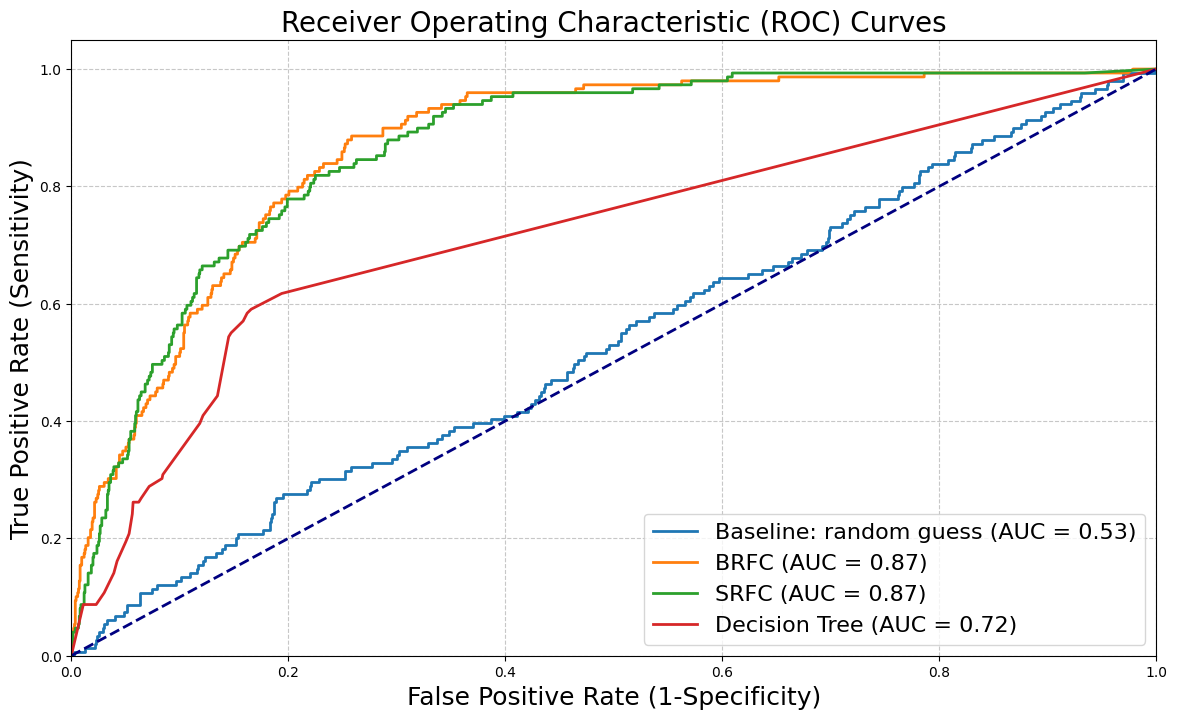


Model Metrics:
Model: Baseline: random guess
  tn: 669
  fp: 682
  fn: 69
  tp: 80
  sensitivity: 53.69
  specificity: 49.52
  roc_auc: 0.53
--------------------------------------------------
Model: BRFC
  tn: 971
  fp: 380
  fn: 17
  tp: 132
  sensitivity: 88.59
  specificity: 71.87
  roc_auc: 0.87
--------------------------------------------------
Model: SRFC
  tn: 1325
  fp: 26
  fn: 126
  tp: 23
  sensitivity: 15.44
  specificity: 98.08
  roc_auc: 0.87
--------------------------------------------------
Model: Decision Tree
  tn: 1274
  fp: 77
  fn: 110
  tp: 39
  sensitivity: 26.17
  specificity: 94.3
  roc_auc: 0.72
--------------------------------------------------
models = ['Baseline: random guess', 'BRFC', 'SRFC', 'Decision Tree']
sensitivity = [53.69, 88.59, 15.44, 26.17]
specificity = [49.52, 71.87, 98.08, 94.3]


['brfc_model.joblib']

In [32]:
# Model selection: 
y_true = preprocessed_df["stroke"]
X = preprocessed_df.drop(columns=["stroke", "age_binned", "avg_glucose_level_binned", "bmi_binned"])

# Implement random guess as baseline model
# For random guess, generate random probabilities between 0 and 1
y_baseline = np.random.rand(len(y_true))

# Split the data once for all models
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=2, stratify=y_true)

models = [
    {
        "name": "Baseline: random guess",
        "classifier": None,  # No classifier for baseline
        "baseline_pred": y_baseline  # Baseline predictions (random probabilities)
    },
    {
        "name": "BRFC",
        "classifier": BalancedRandomForestClassifier(n_estimators=100, random_state=2, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_jobs=-1),
    },
    {
        "name": "SRFC",
        "classifier": RandomForestClassifier(n_estimators=100, random_state=2, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_jobs=-1),
    },
    {
        "name": "Decision Tree",
        "classifier": DecisionTreeClassifier(random_state=2, max_depth=20, min_samples_leaf=3, min_samples_split=10)
    }
]

# Dictionary to store all metrics
metrics_dict = {}

# Function to compute the confusion matrix, print results and plot ROC curve
def evaluate_model(classifier, X_train, X_test, y_train, y_test, model_name, baseline=False, y_baseline_pred=None):
    if baseline:
        y_prob = y_baseline_pred[X_test.index]  # Use the random guess probabilities for baseline
        y_pred = np.where(y_prob > 0.5, 1, 0)  # Convert probabilities to class labels (0 or 1) --> threshold = 0.5 (proba > 0.5 : stroke ==1)
    else:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc')
        mean_score = np.mean(scores)
        print(f"{model_name} - Mean ROC-AUC: {mean_score:.3f}")

        # Train the model
        classifier.fit(X_train, y_train)

        # Make predictions
        y_pred = classifier.predict(X_test)
        y_prob = classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Compute sensitivity and specificity
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100

    print(f"{model_name} - Sensitivity: {sensitivity:.0f}%, Specificity: {specificity:.0f}%")
    print("--------------------------------------------------")

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Save metrics to dictionary
    metrics_dict[model_name] = {
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "sensitivity": round(sensitivity, 2),
        "specificity": round(specificity, 2),
        "roc_auc": round(roc_auc, 2),
        "fpr": fpr,
        "tpr": tpr
    }

    return fpr, tpr, roc_auc

# Plot ROC curves
fig, ax = plt.subplots(figsize=(14, 8))

for model in models:
    print(f"Training {model['name']}...")
    classifier = model["classifier"]

    if classifier is not None:
        fpr, tpr, roc_auc = evaluate_model(classifier, X_train, X_test, y_train, y_test, model['name'])
    else:
        # Baseline model: use the provided baseline predictions (random guess)
        fpr, tpr, roc_auc = evaluate_model(None, X_train, X_test, y_train, y_test, model['name'], baseline=True, y_baseline_pred=y_baseline)

    plt.plot(fpr, tpr, lw=2, label=f'{model["name"]} (AUC = {roc_auc:.2f})')


ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])  # Set x-axis limits
ax.set_ylim([0.0, 1.05])  # Set y-axis limits
ax.set_xlabel('False Positive Rate (1-Specificity)', fontsize=18)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=18)
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=20)
ax.legend(fontsize=16, loc='lower right')
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Print all metrics
print("\nModel Metrics:")
for model_name, metrics in metrics_dict.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        if isinstance(metric_value, np.ndarray):  # Skip printing arrays
            continue
        print(f"  {metric_name}: {metric_value}")
    print("--------------------------------------------------")



# Extract the desired metrics into separate lists
model_names = []
sensitivities = []
specificities = []

for model_name, metrics in metrics_dict.items():
    model_names.append(model_name)
    sensitivities.append(metrics["sensitivity"])
    specificities.append(metrics["specificity"])

# Print the lists
print("models =", model_names)
print("sensitivity =", sensitivities)
print("specificity =", specificities)

# Save the model to a file
joblib.dump(models[1]["classifier"], 'brfc_model.joblib')  # Saving BRFC as an example


Training BRFC...
BRFC - Mean recall: 0.883
BRFC - Sensitivity: 94%, Specificity: 73%
--------------------------------------------------


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future

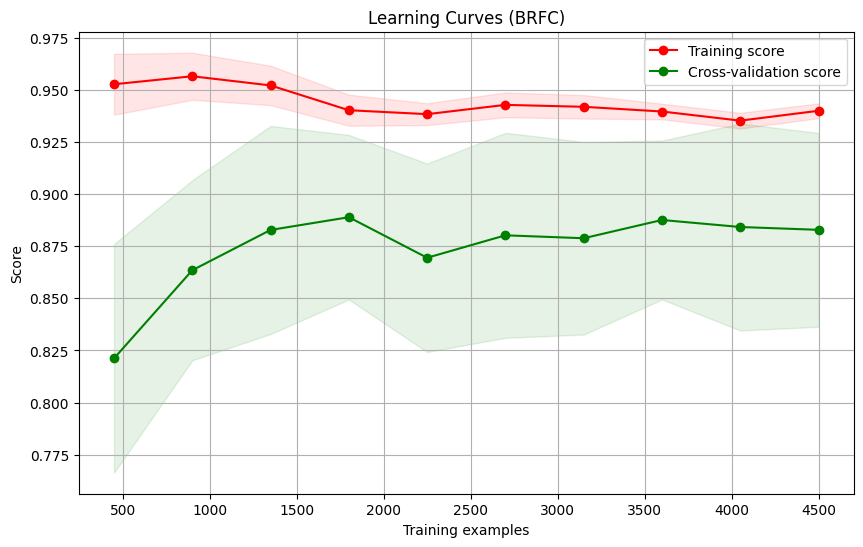

Training SRFC...
SRFC - Mean recall: 0.164
SRFC - Sensitivity: 37%, Specificity: 100%
--------------------------------------------------


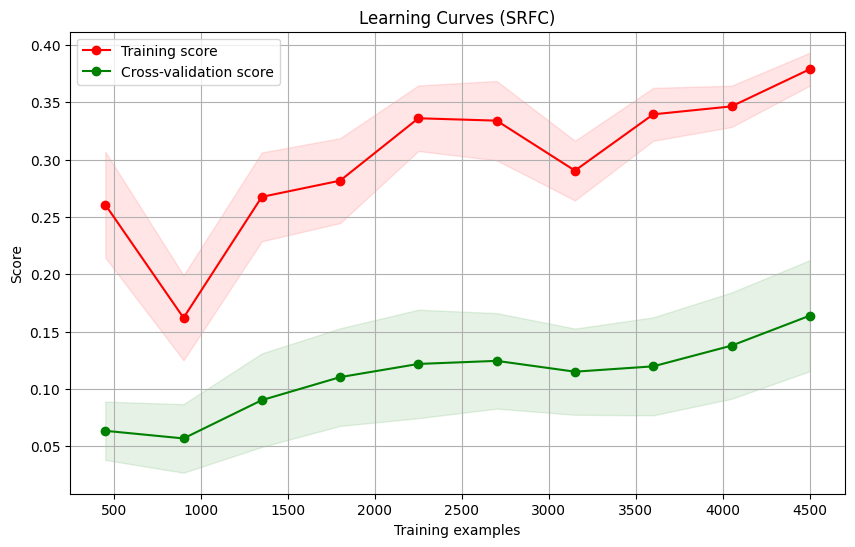

Training Decision Tree...
Decision Tree - Mean recall: 0.268
Decision Tree - Sensitivity: 62%, Specificity: 98%
--------------------------------------------------


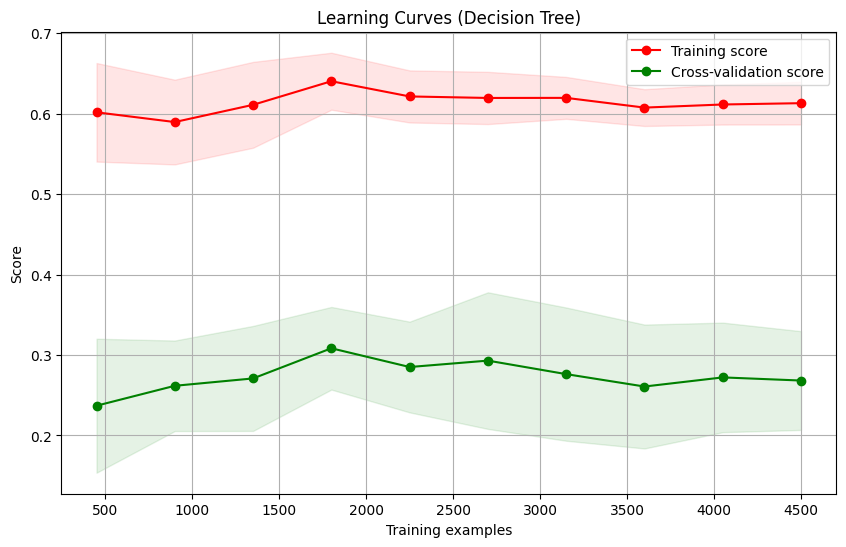

In [20]:
#Plot lerning curve with recall/sensitive score
y = df["stroke"]
models = [

    {
        "name": "BRFC",
        "classifier": BalancedRandomForestClassifier(n_estimators=100, random_state=2, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_jobs=-1),
    },
    {
        "name": "SRFC",
        "classifier": RandomForestClassifier(n_estimators=100, random_state=2, max_depth=20, min_samples_leaf=3, min_samples_split=10, n_jobs=-1),
    },
    {
        "name": "Decision Tree",
        "classifier": DecisionTreeClassifier(random_state=2, max_depth=20, min_samples_leaf=3, min_samples_split=10)
    }
]

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(recall_score)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Train and evaluate models
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for model in models:
    print(f"Training {model['name']}...")
    classifier = model["classifier"]
    
    # Compute scores using cross-validation
    scores = cross_val_score(classifier, X, y, cv=cv, scoring=make_scorer(recall_score))
    
    # Output mean scores
    mean_score = np.mean(scores)
    print(f"{model['name']} - Mean recall: {mean_score:.3f}")
    
    # Train the model
    classifier.fit(X, y)
    
    # Make predictions
    y_pred = classifier.predict(X)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Compute sensitivity and specificity
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    
    print(f"{model['name']} - Sensitivity: {sensitivity:.0f}%, Specificity: {specificity:.0f}%")
    print("--------------------------------------------------")
    
    # Plot learning curve
    plot = plot_learning_curve(classifier, f"Learning Curves ({model['name']})", X, y, cv=cv)
    plot.show()

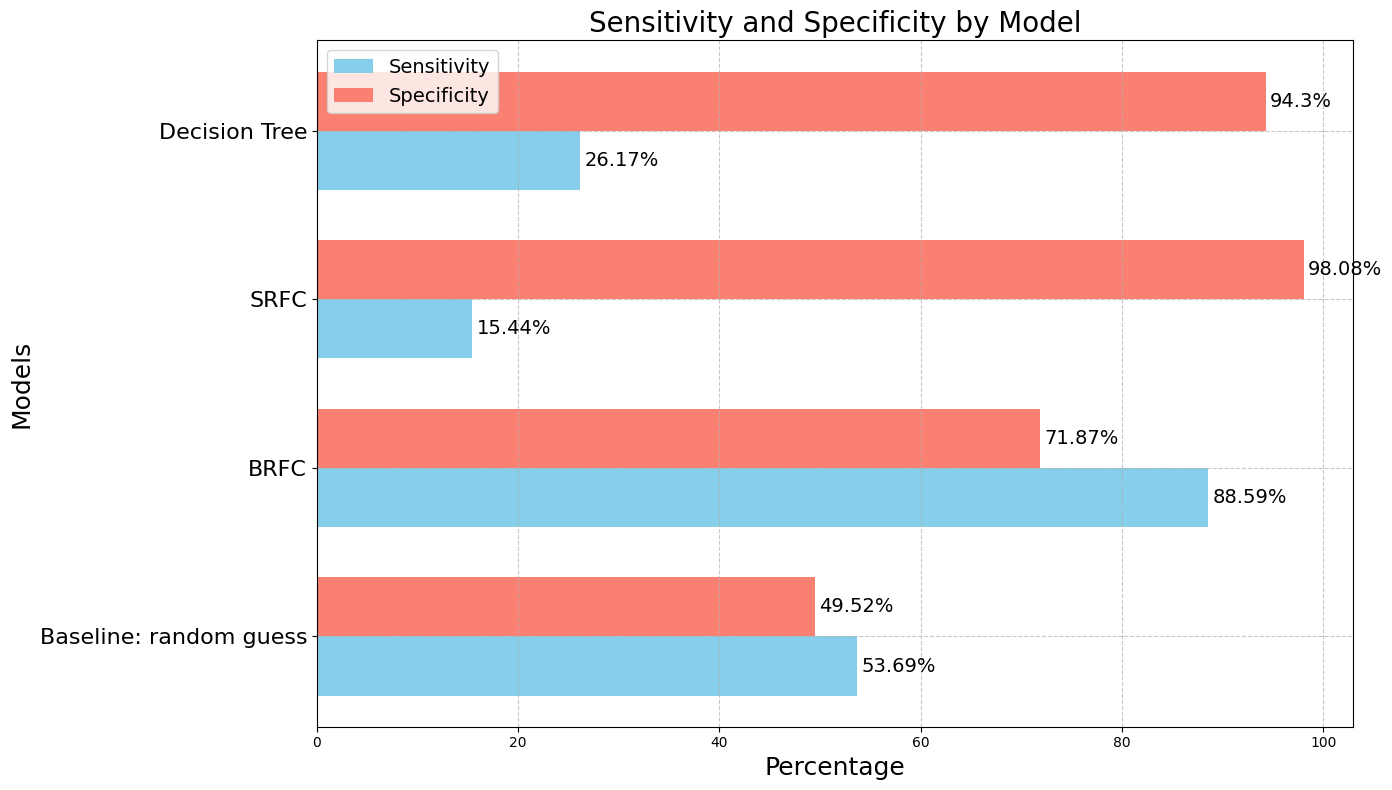

In [38]:
#Sensitivity-Specificity plot with different models 
models = ['Baseline: random guess', 'BRFC', 'SRFC', 'Decision Tree']
sensitivity = [53.69, 88.59, 15.44, 26.17]
specificity = [49.52, 71.87, 98.08, 94.3]


# Create horizontal bar plot
x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.barh(x - width/2, sensitivity, width, label='Sensitivity', color='skyblue')
bars2 = ax.barh(x + width/2, specificity, width, label='Specificity', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percentage', fontsize=18)
ax.set_ylabel('Models', fontsize=18)
ax.set_title('Sensitivity and Specificity by Model', fontsize=20)
ax.set_yticks(x)
ax.set_yticklabels(models, fontsize=16)
ax.legend(fontsize=14, loc='upper left') 
ax.grid(True, linestyle='--', alpha=0.7)

# Attach a text label above each bar in *bars1* and *bars2*, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width}%',
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center', fontsize=14)

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()

## Hyperparameter tuning 

According to the results, the best model performance is the BRFC model with the following metrics:

roc_auc: 0.87
sensitivity: 88.59
specificity: 71.87

- Although the SRFC model have very similar the performance in the roc_auc metric, due to the task that we want to predict the stroke probability of patients, it is more importance that our prediction have high sensitivity (88%, instead of 15% in the SRFC model).
- Furthermore the learning curve with the sensivity score of the BRFC model shows a strong perfomance and does not overfitting.

For the hyperarameter tuning, the randomized search beside the repeated stratified K-fold cross validation was used to find the best parameters of the BRFC model. 

Finally, the BRFC model with the best hyperparameters from the RandomizedSearchCV on the entire training dataset.
  

In [43]:
#Hyperarameter tuning

# Define the parameter grid for BRFC
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],   # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 50],        # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 10],          # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider for the best split
    'bootstrap': [True, False],                 # Whether to bootstrap samples when building trees
    'class_weight': [None, 'balanced']          # Class weighting for imbalanced data
}

# Your dataset
y_true = preprocessed_df["stroke"]
X = preprocessed_df.drop(columns=["stroke"])

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=2, stratify=y_true)

# Initialize the BRFC model
brfc = BalancedRandomForestClassifier(random_state=2)

# Create RepeatedStratifiedKFold cross-validation object
repeated_strat_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Set up RandomizedSearchCV with RepeatedStratifiedKFold cross-validation
random_search = RandomizedSearchCV(
    estimator=brfc,               # The model to optimize
    param_distributions=param_grid, # Parameter grid
    n_iter=100,                   # Number of random combinations to try
    scoring='roc_auc',            # Scoring metric to optimize (ROC-AUC)
    cv=repeated_strat_kfold,      # Repeated Stratified K-Fold cross-validation
    verbose=2,                    # Print output during training
    random_state=42,              # For reproducibility
    n_jobs=-1                     # Use all available CPU cores
)

# Fit the random search model
random_search.fit(X_train, y_train)



Fitting 30 folds for each of 100 candidates, totalling 3000 fits


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=bala

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balance

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balance

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=bala

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_dep

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=5

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=None

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=20, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=l

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=l

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_feat

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_feat

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_d

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balan

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=30, m

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balan

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_feat

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, cl

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, cl

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_fe

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_dept

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, ma

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, cl

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_we

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_we

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weigh

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_dep

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=bala

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_wei

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, ma

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_fe

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=5

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_dep

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balance

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, ma

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_dept

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_f

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_f

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balan

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_d

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_dep

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_dep

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balance

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, ma

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_fe

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=20, ma

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=None,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_d

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=b

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, ma

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, class_we

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, m

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, cl

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, cl

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=50

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_feat

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=50, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=None

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_featur

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_fe

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.7s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=30,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, class_weight=balan

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.6s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, class_weight=

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=No

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, class_weight=None, max_dep

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=Fal

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=Fal

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, class_weight=None, max_depth=20, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_f

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, class_weight=None, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s


/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_dept

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=30, max_features=sqrt,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20,

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_fe

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, 

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_we

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=bala

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=bala

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balance

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future

[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, class_weight=ba

/Users/nicha/ida-venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
750 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
254 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicha/ida-venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicha/ida-venv/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/nicha/ida-venv/lib/python3.12/site-packages/imblearn/base.py", line 42, in _validate_params
    validate_parameter_constraints(
  File "/Users/

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
Tuned BRFC - Sensitivity: 88.59%
Tuned BRFC - Specificity: 72.46%
Tuned BRFC - ROC AUC: 0.871


In [44]:
# Print the best parameters found
print("Best hyperparameters:", random_search.best_params_)

# Get the best model after hyperparameter tuning
best_brfc = random_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred = best_brfc.predict(X_test)
y_prob = best_brfc.predict_proba(X_test)[:, 1]

# Compute confusion matrix and ROC AUC for the best model
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Tuned BRFC - Sensitivity: {sensitivity:.2f}%")
print(f"Tuned BRFC - Specificity: {specificity:.2f}%")
print(f"Tuned BRFC - ROC AUC: {roc_auc:.3f}")


Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
Tuned BRFC - Sensitivity: 88.59%
Tuned BRFC - Specificity: 72.46%
Tuned BRFC - ROC AUC: 0.871


In [49]:
#Train the entire training dataset with the best params of BRFC model
y_train = preprocessed_df["stroke"]
X_train = preprocessed_df.drop(columns=["stroke"])

best_params = random_search.best_params_

# Create a new instance of BRFC with the best parameters
best_brfc = BalancedRandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    class_weight=best_params['class_weight'],
    random_state=2
)

# Train the BRFC model on the entire training dataset
best_brfc.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(best_brfc, 'best_brfc_model.joblib')
print("Best BRFC model has been trained and saved as 'best_brfc_model.joblib'.")


Best BRFC model has been trained and saved as 'best_brfc_model.joblib'.


## Predicted the test data

- preprocessed the test dataset the same way as training set.

In [50]:
# Load the saved model
brfc_model = joblib.load('brfc_model.joblib')
best_brfc_model = joblib.load('best_brfc_model.joblib')

#load test data
test_df = pd.read_csv("test.csv")

test_df.head()

id  gender  age  hypertension  heart_disease      work_type  \
0  5000  Female   69             0              0        Private   
1  5001    Male   67             0              0        Private   
2  5002    Male   89             0              0       Govt_job   
3  5003  Female   68             0              0  Self-employed   
4  5004  Female  100             0              0       Govt_job   

  Residence_type  avg_glucose_level    bmi smoking_status  
0          Rural         103.052305  28.20   never smoked  
1          Urban         101.482305  55.08   never smoked  
2          Rural          96.332305    NaN        Unknown  
3          Urban          72.262305  28.92   never smoked  
4          Rural          58.632305    NaN        Unknown

In [37]:
#preprocess the test data with the same imputer like in the training data

test_avg_glucose_level = simple_imputer.transform(test_df[['avg_glucose_level']])
test_bmi = knn_imputer.transform(test_df[['bmi']])


# Transform categorical columns of the test data
test_encoded_categorical_data = ohe.transform(test_df[categorical_columns])
test_encoded_categorical_df = pd.DataFrame(
    test_encoded_categorical_data, 
    columns=ohe.get_feature_names_out(categorical_columns)
)

preprocessed_test_df = pd.concat([test_df[numerical_columns], test_encoded_categorical_df], axis=1)

preprocessed_test_df.head()


age  avg_glucose_level    bmi  gender_Male  work_type_Never_worked  \
0   69         103.052305  28.20          0.0                     0.0   
1   67         101.482305  55.08          1.0                     0.0   
2   89          96.332305    NaN          1.0                     0.0   
3   68          72.262305  28.92          0.0                     0.0   
4  100          58.632305    NaN          0.0                     0.0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                1.0                      0.0                 0.0   
1                1.0                      0.0                 0.0   
2                0.0                      0.0                 0.0   
3                0.0                      1.0                 0.0   
4                0.0                      0.0                 0.0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                   0.0                             0.0   
1                   1.0                             0.0   
2                   0.0                             0.0   
3                   1.0                             0.0   
4                   0.0                             0.0   

   smoking_status_never smoked  smoking_status_smokes  
0                          1.0                    0.0  
1                          1.0                    0.0  
2                          0.0                    0.0  
3                          1.0                    0.0  
4                          0.0                    0.0

In [41]:
# Predicted probabilities for the test dataset and saved in y_test_pred.csv w/o tuning
stroke_probabilities = brfc_model.predict_proba(preprocessed_test_df)[:, 1]  # Get probabilities for the positive class

# Create submission DataFrame
y_test_pred = pd.DataFrame({
    "id": np.arange(5_000, 6_000),  # Assuming test set ID starts from 5000
    "stroke": stroke_probabilities   # Your predicted probabilities
})

# Save the submission DataFrame to a CSV file
y_test_pred.to_csv("y_test_pred.csv", index=False)

# Optional: Display the first few entries of the submission file to check
print("Submission File Preview:")
print(y_test_pred.head())

Submission File Preview:
     id    stroke
0  5000  0.151403
1  5001  0.234373
2  5002  0.622876
3  5003  0.221244
4  5004  0.660729


In [51]:
# Predicted probabilities for the test dataset and saved in y_test_pred_tuning.csv 
stroke_probabilities = best_brfc_model.predict_proba(preprocessed_test_df)[:, 1]  # Get probabilities for the positive class

# Create submission DataFrame
y_test_pred_tuning = pd.DataFrame({
    "id": np.arange(5_000, 6_000),  # Assuming test set ID starts from 5000
    "stroke": stroke_probabilities   # Your predicted probabilities
})

# Save the submission DataFrame to a CSV file
y_test_pred_tuning.to_csv("y_test_pred_tuning.csv", index=False)

# Optional: Display the first few entries of the submission file to check
print("Submission File Preview:")
print(y_test_pred_tuning.head())

Submission File Preview:
     id    stroke
0  5000  0.164299
1  5001  0.196641
2  5002  0.616494
3  5003  0.236380
4  5004  0.730268
